## **SISTEMA RECOMENDADOR DE NOTICIAS PARA CLIENTES CORPORATIVOS DE UN BANCO**



**Profesor**: Juan Fernando Perez Bernal

**Integrantes**: Miller Puentes, Joan Esteban Chacón, Grace González, Catalina Cárdenas


En este documento se presenta el análisis exploratorio de los datos para el desarrollo de un sistema de recomendación de noticias para los clientes de un banco basado en el sector económico al que pertenece.

### ***Tabla de contenido***

**0.   Instalación y llamada de librerías**

  0.1 Instalación de pyLDAvis

  0.2 Instalación de librerías

**1.   Análisis Descriptivo**
  
  1.1 Clientes
  
  1.2 Noticias
  
  1.3 Clientes_noticias

**2.   Preprocesamiento de datos**

  2.1 Selección de variables

  2.2 Eliminación de noticias duplicadas

  2.3 Conversión a minúsculas, eliminación de caracteres especiales, espacios en blanco, y reemplazo de nombres de meses y días

  2.4 Eliminación de stopwords

  2.5.1 Stemming de textos

  2.5.2 Lematización de textos

  2.6 Guardado de limpieza de datos

  2.6.1 Stemming de textos

  2.6.2 Lematización de textos


## ***0. Instalación y llamada de librerías***

### ***0.1 Instalación de pyLDAvis***

In [1]:
import pandas as pd
import numpy as np
import pyLDAvis

print(pd.__version__)
print(np.__version__)
print(pyLDAvis.__version__)

2.0.0
1.24.3
3.4.0


### ***0.2 Instalación de librerías***

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.expand_frame_repr', False)
# pd.set_option('display.max_colwidth', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unidecode
import spacy
from spacy.lang.es.examples import sentences
from unidecode import unidecode
import zipfile
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import nltk
import pyLDAvis.gensim_models
from gensim.corpora import Dictionary
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
# from transformers import AutoModel, AutoTokenizer
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from wordcloud import WordCloud
from pprint import pprint
from gensim.models import LdaModel

# Visualizamos los resultados
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Cargar el modelo de spacy para el español
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\relat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\relat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\relat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\relat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## ***1. Análisis descriptivo***

### Carga de archivos
Para realizar el análisis descriptivo del dataset, se cargan los datos de los archivos *clientes.csv,clientes_noticias.csv,* y *noticias.csv*, en diferentes dataframe para evaluar sus características.  


---



---






In [5]:
df_clientes=pd.read_csv('../Data/clientes.csv')
df_clientes_noticias=pd.read_csv('../Data/clientes_noticias.csv')
df_noticias=pd.read_csv('../Data/noticias.csv')

In [6]:
# Visualización clientes
df_clientes.head(2)

,nit,nombre,desc_ciiu_division,desc_ciuu_grupo,desc_ciiuu_clase,subsec
0,805027024,SUPERMERCADO LA GRAN COLOMBIA SA,ELABORACION DE PRODUCTOS ALIMENTICIOS,"PROCESAMIENTO Y CONSERVACION DE CARNE, PESCADO...",PROCESAMIENTO Y CONSERVACION DE CARNE Y PRODUC...,CARNES FRIAS
1,890100026,CAMAGUEY SA,ELABORACION DE PRODUCTOS ALIMENTICIOS,"PROCESAMIENTO Y CONSERVACION DE CARNE, PESCADO...",PROCESAMIENTO Y CONSERVACION DE CARNE Y PRODUC...,CARNES FRIAS


In [7]:
# Visualización clientes_noticias
df_clientes_noticias.head(2)

,nit,news_id,news_url_absolute,news_init_date,news_final_date
0,900378212,news10006,https://www.bluradio.com/economia/precio-dolar...,2022-07-30,2022-08-14
1,900378212,news10011,https://www.semana.com/economia/macroeconomia/...,2022-07-30,2022-08-14


In [8]:
# Visualización noticias
df_noticias.head(2)

,news_id,news_url_absolute,news_init_date,news_final_date,news_title,news_text_content
0,news10006,https://www.bluradio.com/economia/precio-dolar...,2022-07-30,2022-08-14,Precio dolar hoy: la cotizacion de la divisa a...,"Este martes, 2 de agosto, el dolar alcanzo un ..."
1,news10011,https://www.semana.com/economia/macroeconomia/...,2022-07-30,2022-08-14,Es cierto: El presidente Gustavo Petro quiere ...,No hay nada mas permanente que lo temporal y a...


In [9]:
print("Las dimensiones de df_clientes son: "+ str(df_clientes.shape))
print("Las dimensiones de df_clientes_noticias son: "+ str(df_clientes_noticias.shape))
print("Las dimensiones de df_noticias son: " + str(df_noticias.shape))

Las dimensiones de df_clientes son: (1507, 6)
Las dimensiones de df_clientes_noticias son: (74709, 5)
Las dimensiones de df_noticias son: (23377, 6)


### ***1.1 Clientes***

El archivo ***clientes.csv*** contiene el listado de clientes a consultar, la descripción de su actividad económica y el subsector. Sus columnas son:

In [10]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507 entries, 0 to 1506
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   nit                 1507 non-null   int64 
 1   nombre              1507 non-null   object
 2   desc_ciiu_division  1507 non-null   object
 3   desc_ciuu_grupo     1507 non-null   object
 4   desc_ciiuu_clase    1507 non-null   object
 5   subsec              1507 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.8+ KB


* nit: Identificador único del cliente (Número entero)
* nombre: Nombre corporativo del cliente (Tipo texto)
* desc_ciiu_división: Descripción general de la clasificación Industrial uniforme d todas las actividades económicas (Tipo texto)
* desc_ciiu_grupo: Descripción por grupo de la clasificación Industrial uniforme d todas las actividades económicas (Tipo texto)
* desc_ciiu_clase: : Descripción por clase de la clasificación Industrial  uniforme de todas las actividades económicas (Tipo texto)
* subsector: Clasificación de la actividad industrial (Tipo texto)

In [11]:
# Exploración
print("Valores únicos por NIT: "+str(df_clientes['nit'].nunique()))
print("")
print("Valores nulos: ")
print(df_clientes.isnull().sum())
print("")
print("Agrupados por subsector: ")
print(df_clientes['subsec'].value_counts())

Valores únicos por NIT: 1507

Valores nulos: 
nit                   0
nombre                0
desc_ciiu_division    0
desc_ciuu_grupo       0
desc_ciiuu_clase      0
subsec                0
dtype: int64

Agrupados por subsector: 
subsec
SERVICIOS A EMPRESAS           142
EDIFICACIONES                  111
OTROS SERVICIOS FINANCIEROS     94
SERVICIOS A PERSONAS            81
OBRAS DE INFRAESTRUCTURA        62
                              ... 
RESINAS PLASTICAS                2
PINTURAS Y BARNICES              2
CONFITERIA                       1
PESCA Y ATUN                     1
COMERCIO DE CAFE                 1
Name: count, Length: 83, dtype: int64


Se tienen 1.507 clientes diferentes, al agrupar los clientes por su clasificación de actividad industrial se encuentra que existen datos relacionados con 83 tipos de subsectores, los que más clientes asociados tienen son *Servicios a empresas, edificaciones y otros servicios financieros*; por otro lado, los subsectores que menos clientes asociados tienen son *Confitería, Pesca y atún y, Comercio de café*. No hay datos nulos.

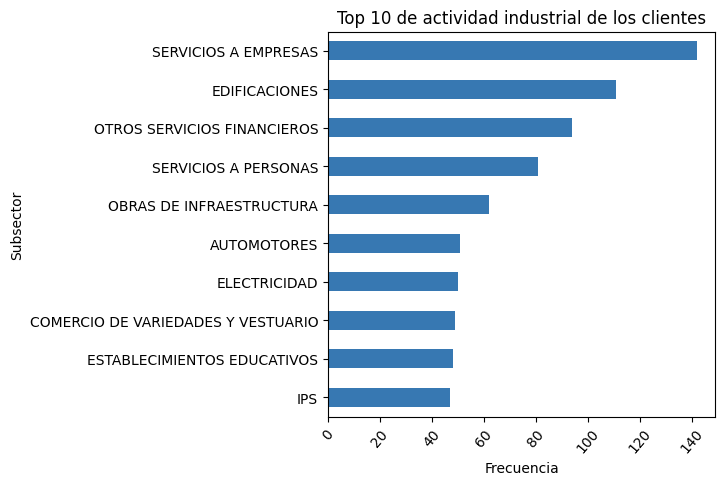

In [12]:
# Calcula el espacio vertical entre las barras
espacio_entre_barras = 5

# Configura los valores en el eje y y ajusta los límites
y_pos = np.arange(len('Subsector')) * (1 + espacio_entre_barras)

RGB = (0.2157, 0.4706, 0.6980)
plt.figure(figsize=(5, 5))
df_clientes['subsec'].value_counts().head(10).sort_values().plot(kind='barh', color=RGB)
plt.title('Top 10 de actividad industrial de los clientes')
plt.xlabel('Frecuencia')
plt.ylabel('Subsector')
plt.xticks(rotation=50)
plt.show()

In [13]:
df_clientes['subsec'].value_counts().describe()

count     83.000000
mean      18.156627
std       24.831374
min        1.000000
25%        5.000000
50%        9.000000
75%       18.000000
max      142.000000
Name: count, dtype: float64

Esto indica que se tienen datos de 83 subsectores diferentes a lo largo del set de datos y el que mayor número de clientes tiene es el subsector de "Servicios a empresas" y "Edificaciones" como lo muestra el gráfico.

En promedio, la actividad en los subsectores tiende a estar alrededor de 18.16 unidades. Se puedes considerar esto como un valor representativo del nivel medio de actividad en estos subsectores. La desviación estándar es 24.83 indicando la dispersión de los datos, lo que sugiere que la actividad industrial en los subsectores varía considerablemente.

Analisando los cuartiles, el 75% de los subsectores tienen una actividad igual o menor que 18, lo que dista mucho de los valores encontrados en el ultimo 25% que presenta valores de hasta 142 como máximo lo que se observa en la gráfica de barras.

### **1.2 Clientes_noticias**


El archivo ***clientes_noticias.csv*** contiene la relación entre cliente y las noticias consultadas mediante el proceso de descarga de información. Sus columnas son:



In [14]:
df_clientes_noticias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74709 entries, 0 to 74708
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   nit                74709 non-null  int64 
 1   news_id            74709 non-null  object
 2   news_url_absolute  74709 non-null  object
 3   news_init_date     74709 non-null  object
 4   news_final_date    74709 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.9+ MB


* new_id: Identificador único del cliente (Número entero)
* news_url_absolute: url de la noticia encontrada (Tipo texto)
* news_init_date: Fecha mínima del intevalo de tiempo al que pertenece la noticia (Tipo texto)
* news_final_date: Fecha máxima del del intevalo de tiempo al que pertenece la noticia (Tipo texto)

Se relacionan con los clientes a través de la columna nit, la cual está inmersa en el archivo *clientes.csv*.

In [15]:
# Exploración
print("Valores únicos por ID de noticia: "+str(df_clientes_noticias['news_id'].nunique()))
print("")
print("Valores únicos por URL de noticia: "+str(df_clientes_noticias['news_url_absolute'].nunique()))
print("")
print("Valores nulos: ")
print(df_clientes_noticias.isnull().sum())
print("")

Valores únicos por ID de noticia: 23377

Valores únicos por URL de noticia: 23116

Valores nulos: 
nit                  0
news_id              0
news_url_absolute    0
news_init_date       0
news_final_date      0
dtype: int64



Se tienen 23.377 noticias diferentes con 23.116 direcciones URL diferentes, lo que sugiere que hay URLs que comparten el mismo identificador de noticia.

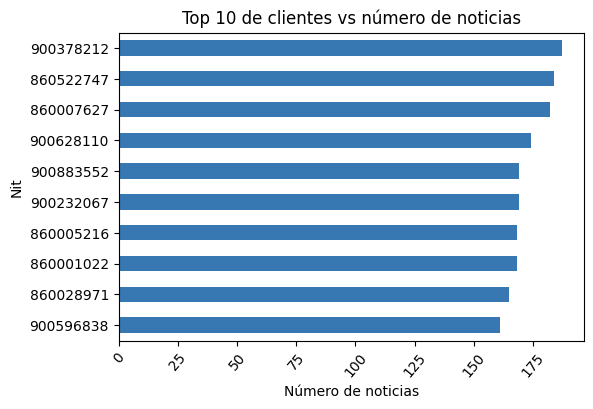

In [16]:
# Calcula el espacio vertical entre las barras
espacio_entre_barras = 5

# Configura los valores en el eje y y ajusta los límites
y_pos = np.arange(len('NIT')) * (1 + espacio_entre_barras)

RGB = (0.2157, 0.4706, 0.6980)
plt.figure(figsize=(6, 4))
df_clientes_noticias['nit'].value_counts().head(10).sort_values().plot(kind='barh', color=RGB)
plt.title('Top 10 de clientes vs número de noticias')
plt.xlabel('Número de noticias')
plt.ylabel('Nit')
plt.xticks(rotation=50)
plt.show()

In [17]:
df_clientes_noticias['nit'].value_counts().describe()

count    1508.000000
mean       49.541777
std        34.210484
min         4.000000
25%        27.000000
50%        36.000000
75%        60.000000
max       187.000000
Name: count, dtype: float64

Dentro de los clientes el 75% de ellos han recibido hasta 60 noticias. Sin embargo, el 25% de los mismo han recibido hasta 187 noticias, lo que sugiere que pueden estar recibiendo información de más de un sector en específico.

### ***1.3 Noticias***

El archivo ***noticias.csv*** contiene cada una de las noticias consultadas. Sus columnas son:



In [18]:
df_noticias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23377 entries, 0 to 23376
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   news_id            23377 non-null  object
 1   news_url_absolute  23377 non-null  object
 2   news_init_date     23377 non-null  object
 3   news_final_date    23377 non-null  object
 4   news_title         23377 non-null  object
 5   news_text_content  23377 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


* new_id: Identificador único de noticias (Tipo texto)
* news_url_absolute: Url de la noticia encontrada (Tipo texto)
* news_init_date: Fecha mínima del intevalo de tiempo al que pertenece la noticia (Tipo texto, pero es una fecha)
* news_final_date: Fecha máxima del del intevalo de tiempo al que pertenece la noticia (Tipo texto, pero es una fecha)
* news_title: Título relacionado a la noticia (Tipo texto)
* news__text__content: Texto contenido de la noticia (Tipo texto)

In [19]:
# Exploración
print("Valores únicos por ID de noticia: "+str(df_noticias['news_id'].nunique()))
print("")
print("Valores únicos por URL de noticia: "+str(df_noticias['news_url_absolute'].nunique()))
print("")
print("Valores únicos por título: "+str(df_noticias['news_title'].nunique()))
print("")
print("Valores nulos: ")
print(df_noticias.isnull().sum())

Valores únicos por ID de noticia: 23377

Valores únicos por URL de noticia: 23116

Valores únicos por título: 22772

Valores nulos: 
news_id              0
news_url_absolute    0
news_init_date       0
news_final_date      0
news_title           0
news_text_content    0
dtype: int64


Se tienen 23.377 noticias diferentes con 23.116 direcciones URL diferentes y 22.722 títulos de noticias únicos, no hay datos nulos, lo que sugiere que hay URLs y títulos que comparten el mismo identificador de noticia.

## ***2. Preprocesamiento de datos***

Los datos de los 3 archivos (ahora dataframes) se relacionan de uno a muchos entre *clientes* y *clientes_noticias* a través del número de identificación tributario **Nit**, así mismo, existe una relación de uno a muchos entre *noticias* y *clientes_noticias* por medio del identificador de noticias **new_id**.

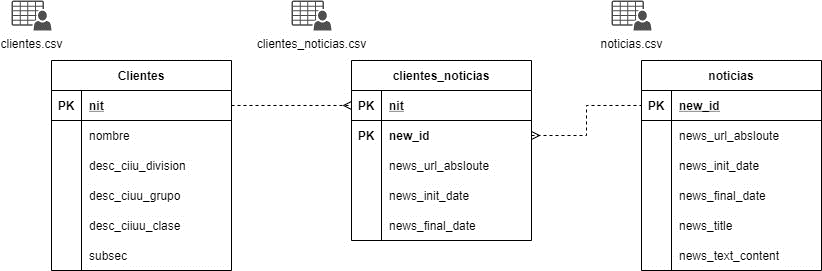

Con el fin de agrupar los clientes por su actividad económica y poder realizar la recomendación de las noticias se realiza una transformación de los datos en acuerdo con el modelo entidad relación mostrado anterioremente.

Para ello se tienen en cuenta las siguientes consignas:

* No se tendrán en cuenta las columnas *news_init_date, news_final_date* de los dataframe *noticias y clientes_noticias* dado que para el ejercicio inicial se tendrán en cuenta el histórico de noticias.

* Para el plantemiento inicial se considerará agrupar los clientes por su clasificación de actividad industrial *subsec*, ya que hacerlo por división o grupo ciiu *(desc_ciiu_division, desc_ciiu_grupo)* podría generar demasiados clusteres dificultando así la recomendación.


### ***2.1 Selección de variables***

En este punto se procede a unir todos los set de datos en uno solo para manejar mejor la información y elegir las columnas que son relevantes para el recomendador.

In [20]:
# Se eliminan la fechas porque no se tendrán en cuenta para el desarrollo
df_bd = df_clientes_noticias.drop(columns=['news_init_date','news_final_date'])
# Se une el set de datos de Clientes_Noticias con el de Clientes
df_bd = pd.merge(df_bd, df_clientes[['nit','subsec','nombre']], on='nit')
# El nuevo DF se une con el set de datos de las noticias
df_bd= pd.merge(df_bd, df_noticias[['news_id', 'news_title', 'news_text_content']], on='news_id').sort_values(by=['nit']).reset_index(drop=True)
df_bd.head(2)

,nit,news_id,news_url_absolute,subsec,nombre,news_title,news_text_content
0,800000946,news15986,https://www.infobae.com/cultura/agenda-cultura...,MANUFACTURA DE PRODUCTOS DE TOCADOR Y ARTICULO...,PROCTER & GAMBLE COLOMBIA LTDA,Guia de Arte y Cultura: semana del 12 al 19 de...,"ARTE Agustina Galindez Quesada exhibe ""Catarsi..."
1,800000946,news89860,https://acento.com.do/economia/wall-street-cie...,MANUFACTURA DE PRODUCTOS DE TOCADOR Y ARTICULO...,PROCTER & GAMBLE COLOMBIA LTDA,Wall Street cierra el viernes en verde,Wall Street cerro en verde este viernes y el D...


Ahora se revisan los valor únicos por columna:

In [21]:
columnas = df_bd.columns
def valores_unicos(df, columnas):
    for i in columnas:
        valores_unicos = df[i].unique()
        print(f"Valores únicos - {i}: {valores_unicos.shape}")

valores_unicos(df_bd, columnas)

Valores únicos - nit: (1507,)
Valores únicos - news_id: (23338,)
Valores únicos - news_url_absolute: (23077,)


Valores únicos - subsec: (83,)
Valores únicos - nombre: (1506,)
Valores únicos - news_title: (22735,)
Valores únicos - news_text_content: (21585,)


In [22]:
# Comparo los valores únicos antes del merge y después del merge.
# news_id
x = 23377 - 23338
# news_url_absolute
y = 23116 - 23077
#news_title
z = 22772 - 22735
print(x,y,z)

39 39 37


* 39 noticias no tienen asociado un cliente por eso hay menos NITs en comparación con el df inicial
* Existen 83 subsectores únicos asociados a 1.507 observaciones. Sin embargo 1 de ellas no tiene 'nombre' del cliente asociado
* Existen 261 news con url repetido
* Existen 1.150 news con el mismo título pero contenido diferente.

Por lo anterior, necesitamos obtener un df nuevo con las noticias únicas.

### ***2.2 Eliminación de noticias duplicadas***

Para eliminar las noticias repetidas se crea una columna llamada 'new_title_content'

In [23]:
# Creamos una nueva columna con valores únicos del título + el contenido de la noticia para luego proceder a eliminar noticias repetidas
df_bd['new_title_content'] = df_bd['news_title'] + ' ' + df_bd['news_text_content']
# Eliminamos filas con valores duplicados en la nueva columna creada 'new_title_content'
df_bd.drop_duplicates(subset='new_title_content', inplace=True)
# Para las noticias mantenemos unicamente la columna concatenada
df_bd = df_bd.drop(columns=['news_title','news_text_content'])
df_bd.head(2)

,nit,news_id,news_url_absolute,subsec,nombre,new_title_content
0,800000946,news15986,https://www.infobae.com/cultura/agenda-cultura...,MANUFACTURA DE PRODUCTOS DE TOCADOR Y ARTICULO...,PROCTER & GAMBLE COLOMBIA LTDA,Guia de Arte y Cultura: semana del 12 al 19 de...
1,800000946,news89860,https://acento.com.do/economia/wall-street-cie...,MANUFACTURA DE PRODUCTOS DE TOCADOR Y ARTICULO...,PROCTER & GAMBLE COLOMBIA LTDA,Wall Street cierra el viernes en verde Wall St...


Volvemos a contar valores únicos en el nuevo dataframe

In [24]:
columnas = df_bd.columns
def valores_unicos(df, columnas):
    for i in columnas:
        valores_unicos = df[i].unique()
        print(f"Valores únicos - {i}: {valores_unicos.shape}")

valores_unicos(df_bd, columnas)

Valores únicos - nit: (960,)
Valores únicos - news_id: (23000,)
Valores únicos - news_url_absolute: (22997,)
Valores únicos - subsec: (83,)
Valores únicos - nombre: (959,)
Valores únicos - new_title_content: (23000,)


In [25]:
df_bd.shape

(23000, 6)

En este punto se observa que existen 960 Clientes unicos a los que les ha llegado una noticia. Ahora se continúa a realizar la limpieza de los textos de las noticias.

### ***2.3 Conversión a minúsculas, eliminación de caracteres especiales, espacios en blanco, y reemplazo de nombres de meses y días***

Se procede a implentar la limpieza de las noticias:

In [26]:
# Antes de la limpieza del texto
df_bd['new_title_content'][0][:100] 

'Guia de Arte y Cultura: semana del 12 al 19 de agosto ARTE Agustina Galindez Quesada exhibe "Catarsi'

In [27]:
# Iniciamos a partir de la 3er columna para aplicar estos cambios en ('subsec', 'nombre', 'new_title_content')
for col in df_bd.columns[2:]:
  # Convertimos en minúsculas
  df_bd[col] = df_bd[col].str.lower()
  # Para todas las columnas excepto la url, eliminamos caracteres especiales, y nombres de meses y dias
  if col != 'news_url_absolute':
    # Se retiran las tildes
    df_bd[col] = df_bd[col].astype(str).apply(unidecode)
    # Se eliminan carácteres especiales y signos de puntuación
    df_bd[col] = df_bd[col].replace(r"[^A-Za-z\s]","", regex=True)
    df_bd[col] = df_bd[col].replace(r"\d+","", regex=True) # Se reemplazan números por espacios vacíos
    # Como no se tienen en cuenta las fechas se eliminan meses y dias de la semana
    df_bd[col] = df_bd[col].replace(r"enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre|lunes|martes|miercoles|jueves|viernes|sabado|domingo", "", regex=True)
    # Se eliminan espacios vacíos dobles en el texto con las transformaciones anteriores
    df_bd[col] = df_bd[col].str.split().str.join(' ')
    # Se eliminena las palabras con menos de dos caracteres
    df_bd[col] = df_bd[col].apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 2]))

df_bd.head(2)

,nit,news_id,news_url_absolute,subsec,nombre,new_title_content
0,800000946,news15986,https://www.infobae.com/cultura/agenda-cultura...,manufactura de productos de tocador articulos ...,procter gamble colombia ltda,guia de arte cultura semana del al de arte agu...
1,800000946,news89860,https://acento.com.do/economia/wall-street-cie...,manufactura de productos de tocador articulos ...,procter gamble colombia ltda,wall street cierra el en verde wall street cer...


In [28]:
# posterior a la limpieza del texto
df_bd['new_title_content'][0][:100]

'guia de arte cultura semana del al de arte agustina galindez quesada exhibe catarsis el de las se in'

Se observa que la parte temporal de la noticia fue eliminada quitando los meses y días. Ahora, se procede a eliminar las stopwords.

### ***2.4 Eliminación de Stopwords***

Se procede a eliminar las Stopwords en español

In [29]:
# Obtener las stopwords en español
stopwords_lista = stopwords.words('spanish')

def eliminar_stopwords(texto):
    # Tokenizar el texto en palabras
    palabras = nltk.word_tokenize(texto)

    # Filtrar las palabras que no son stopwords y que tienen más de 2 caracteres
    palabras_filtradas = [palabra for palabra in palabras if palabra.lower() not in stopwords_lista and len(palabra) >= 2]

    # Unir las palabras filtradas en un nuevo texto
    texto_filtrado = ' '.join(palabras_filtradas)

    return texto_filtrado

In [30]:
df_bd['new_title_content'] = df_bd['new_title_content'].apply(lambda x: eliminar_stopwords(x))

In [31]:
#Revisamos que sí se hayan eliminado las stopwords
df_bd['new_title_content'][0][:100] 

'guia arte cultura semana arte agustina galindez quesada exhibe catarsis inaugura nuevo centro cultur'

Ahora inspeccionamos por nubes de palabras algunos de los sectores para validar si los procesos de limpieza mejoraron el contenido de las noticias:

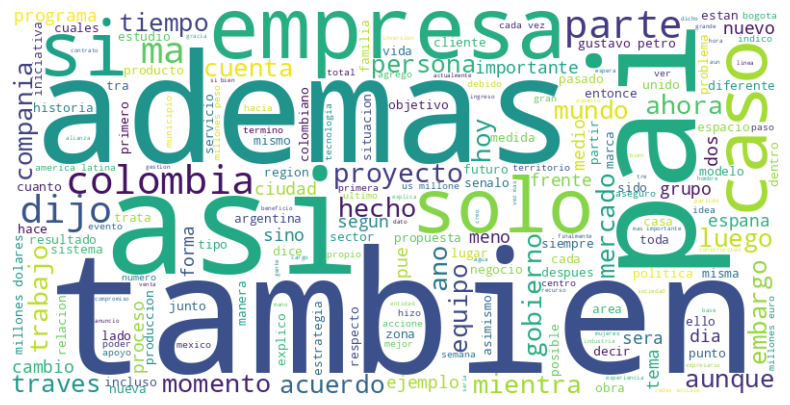

In [32]:
# Se analiza el subsector SERVICIOS A EMPRESAS
df_filtered = df_bd[df_bd['subsec'] == 'SERVICIOS A EMPRESAS']
text = ' '.join(df_bd['new_title_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

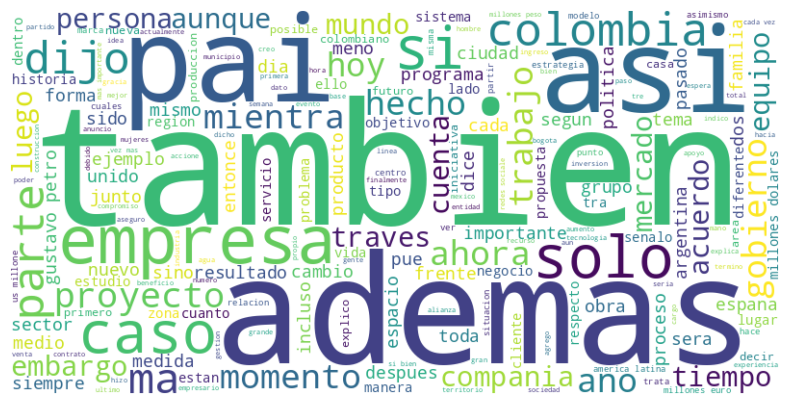

In [33]:
# Se analiza el subsector COMERCIO DE VARIEDADES Y VESTUARIO
df_filtered = df_bd[df_bd['subsec'] == 'COMERCIO DE VARIEDADES Y VESTUARIO']
text = ' '.join(df_bd['new_title_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Con los wordclouds detectamos algunas palabras adicionales a las stopwords que debemos limpiar del texto base. Finalmente como se puede visualizar estas transformaciones sobre los datos facilita la identificación de temas y tendencias en las noticias relacionadas con los clientes bancarios según el subsector al que pertenecen.

*En este punto se toma la decisión de realizar stemming y lematización en el texto de las noticias para comparar las diferentes separaciones y mirar cual es la mejor estrategia de cara al negocio.*

### ***2.5.1 Stemming de textos***

In [34]:
# Creamos un stemmer en español
stemmer = SnowballStemmer('spanish')

def realizar_stemming(texto):
    # Tokenizar el texto en palabras
    palabras = nltk.word_tokenize(texto)

    # Aplicar stemming a cada palabra
    palabras_stemmed = [stemmer.stem(palabra) for palabra in palabras]

    # Unir las palabras stemmeadas en un nuevo texto
    texto_stemmed = ' '.join(palabras_stemmed)

    return texto_stemmed

In [35]:
df_bd_stemming = df_bd.copy()
df_bd_stemming['new_title_content'] = df_bd_stemming['new_title_content'].apply(lambda x: realizar_stemming(x))

In [36]:
#Revisamos el stemming realizado
df_bd_stemming['new_title_content'][0][:100]

'gui arte cultur seman arte agustin galindez ques exhib catarsis inaugur nuev centr cultural borg exp'

Se eliminan sufijos y prefijos de las palabras para obtener su raíz o forma base. Como se observa en resultado del stemming no siempre es una palabra válida en el español. Por ejemplo, ques viene de la palabras quesada como apellido pero puede ser interpretado como si viniera del queso.

Ahora inspeccionamos por nubes de palabras los mismo sectores analizados anteriormente, para validar el proceso de implementación de stemming en las noticias:

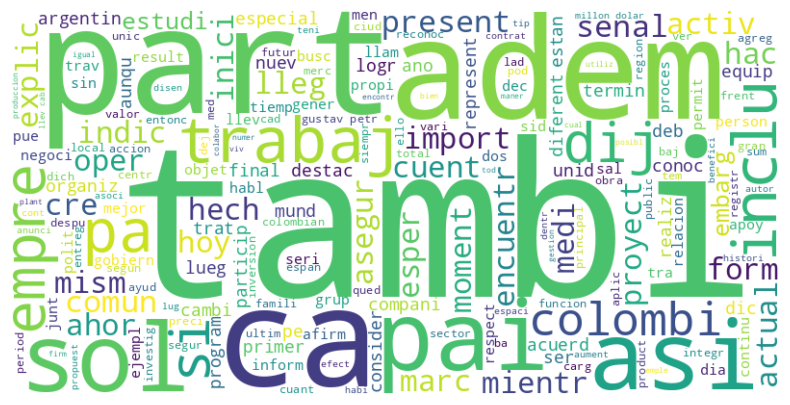

In [37]:
# Se analiza el subsector SERVICIOS A EMPRESAS
df_filtered = df_bd_stemming[df_bd_stemming['subsec'] == 'SERVICIOS A EMPRESAS']
text = ' '.join(df_bd_stemming['new_title_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

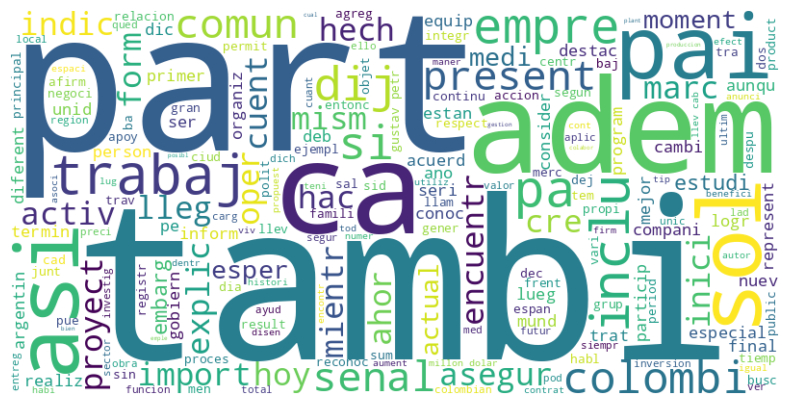

In [38]:
# Se analiza el subsector COMERCIO DE VARIEDADES Y VESTUARIO
df_filtered = df_bd_stemming[df_bd_stemming['subsec'] == 'COMERCIO DE VARIEDADES Y VESTUARIO']
text = ' '.join(df_bd_stemming['new_title_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### ***2.5.2 Lematización de textos***

In [39]:
stopwords_lista = stopwords.words('spanish')

In [40]:
# Procedemos a lematizar
def lematizar(noticia):
    # Lematizamos las palabras
    lemmatizer = WordNetLemmatizer()
    # Tokenizamos el texto en palabras
    word_tokens = word_tokenize(str(noticia))
    # Lematizamos las palabras que no están en las stopwords, ni tienen más de 3 caracteres (previendo textos en inglés)
    tokens = [lemmatizer.lemmatize(w) for w in word_tokens if w not in stopwords_lista and len(w) > 3]
    # Unimos las palabras lematizadas en una cadena de texto
    texto_lematizado = " ".join(tokens)

    return texto_lematizado

In [41]:
df_bd_lemat = df_bd.copy()
df_bd_lemat['new_title_content'] = df_bd_lemat['new_title_content'].apply(lematizar)

In [42]:
#Revisamos el stemming realizado
df_bd_lemat['new_title_content'][0][:100]

'guia arte cultura semana arte agustina galindez quesada exhibe catarsis inaugura nuevo centro cultur'

Se reducen las palabras a sus lemas, que son las formas base o diccionario de las palabras.El resultado de la lematización es siempre una palabra válida en el idioma. Sin embargo, en el español no está muy bien identificado por la cantida de tiempos que tienen los verbos y no se encuentra muchos contribuyentes del software libre apoyando la tarea. Por ejemplo, la lematización del texto muestra la palabra "corriendo" que sería "correr," que es una palabra válida en español.

Ahora inspeccionamos por nubes de palabras los mismo sectores analizados anteriormente, para validar el proceso de implementación de lematización en las noticias:

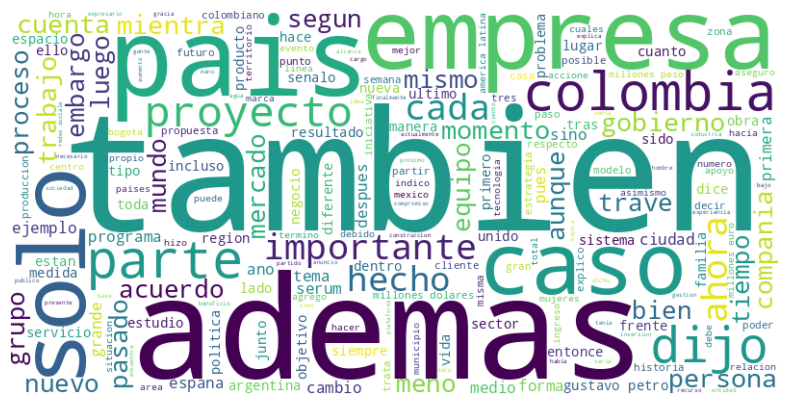

In [43]:
# Se analiza el subsector SERVICIOS A EMPRESAS
df_filtered = df_bd_lemat[df_bd_lemat['subsec'] == 'SERVICIOS A EMPRESAS']
text = ' '.join(df_bd_lemat['new_title_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

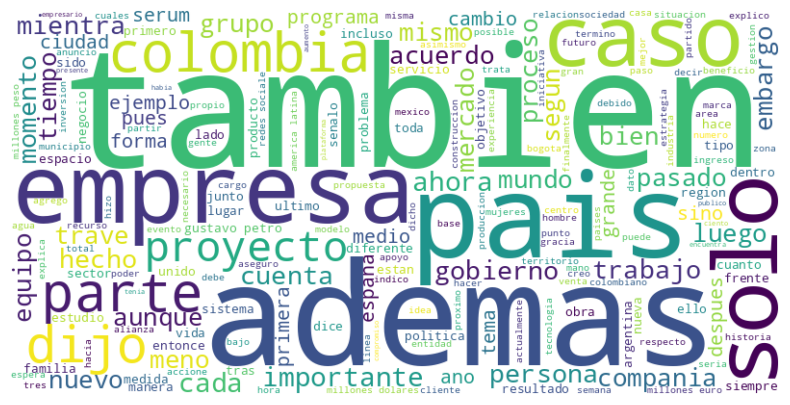

In [44]:
# Se analiza el subsector COMERCIO DE VARIEDADES Y VESTUARIO
df_filtered = df_bd_lemat[df_bd_lemat['subsec'] == 'COMERCIO DE VARIEDADES Y VESTUARIO']
text = ' '.join(df_bd_lemat['new_title_content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### ***2.6 Guardado de limpieza de datos***

***2.6.1 Stemming de textos***

In [45]:
ruta_csv = '../Data/DC_stemming.csv'
df_bd_stemming.to_csv(ruta_csv, index=False)

***2.6.2 Lematización de textos***

In [46]:
ruta_csv = '../Data/DC_lematizacion.csv'
df_bd_lemat.to_csv(ruta_csv, index=False)